# An√°lise de sentimentos de tweets brasileiros nos per√≠odos anterior e inicial da pandemia de Covid-19
***

<img style="float: left;" src="images/menu_resultados.png" width="800" height="500">

## IV - An√°lise dos resultados

Esta etapa apresenta uma **an√°lise dos resultados obtidos** a partir dos **sentimentos de *tweets*** processados pela ferramenta VADER, procedimento realizado no passo anterior deste trabalho.

Ser√£o apresentadas **totaliza√ß√µes de registros** e **quantitativo de registros por localiza√ß√µes** (cidades e estados). 

Para a an√°lise dos sentimentos resultantes, s√£o selecionadas as **100 cidades com maiores quantidades de *tweets***, de forma a englobar todas as capitais ap√≥s a execu√ß√£o de todos filtros aplicados aos registros trabalhados. Tomando este recorte como base, s√£o calculadas as m√©dias de sentimentos nos intervalos anteriores e iniciais da pandemia de Covid-19. Estes intervalos foram divididos em **3 per√≠odos**: **antes do primeiro caso de Covid-19**; **ap√≥s o primeiro caso de Covid-19**; e **ap√≥s a primeira morte por Covid-19**, para cada cidade selecionada.

Ap√≥s esta sele√ß√£o, s√£o criados conjuntos com as cidades com **sentimentos mais negativos** e **sentimentos mais positivos**. Em cima desses conjuntos, s√£o gerados **gr√°ficos de m√©dias de sentimentos por per√≠odo**, **m√©dias de sentimentos por dia** e de **palavras com maior ocorr√™ncia nas frases que mais influenciaram negativamente ou positivamente as m√©dias de sentimentos**.

O intuito destas an√°lises √© observar eventuais **padr√µes comportamentais dos usu√°rios nos diferentes per√≠odos analisados, nos dois conjuntos de cidades observados**.

***
### Importa√ß√µes gerais

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from datetime import datetime
from datetime import timedelta

from statistics import mean

import warnings
warnings.filterwarnings('ignore')

### Configura√ß√µes Iniciais

#### Conex√£o ao banco de dados

In [2]:
# Criando estrutura do banco de dados
from pymongo import MongoClient

# Conex√£o com o servidor do MongoDB
client = MongoClient('localhost', 27017)

# Conex√£o com a base de dados do mongoDB
db = client.SpedDB

# Cole√ß√£o onde ser√£o inseridos os dados
collection = db.tweets_brasil

#### Defini√ß√£o de vari√°veis

Nas c√©lulas abaixo s√£o definidas vari√°veis utilizadas no procedimento de an√°lises de resultados.

A vari√°vel referente √†s *hashtags* armazena *strings* a serem desconsideradas nos gr√°ficos de gera√ß√µes de palavras, por serem palavras comuns ao universo dos registros presentes na base de dados (s√£o, em maioria, *hashtags* utilizadas pelo GeoCoV19 para a coleta de *tweets*).

In [77]:
# Hashtags que ser√£o desconsideradas nos items de processamentos de palavras pois s√£o hashtags base que foram utilizados pelo GeoCov19 para sele√ß√£o de todos os tweets (se repetem em todos os tweets)
default_hashtags = ['#coronav√≠rus','#covid19','#covid2019','#covid19brasil','#covid2019brasil','#covid','#corona','#coronavirusbrasil', '#coronavirusnobrasil', '#coronavirus', '#covid-19', '#covid„Éº19', '#covid_19', '#novocoronav√≠rus']

# N√∫mero m√°ximo de cidades de acordo com a quantidade de tweets
num_max_cidades = 100

# N√∫mero m√≠nimo de dias por per√≠odo analisado
min_num_days = 3

***
### Retornado resultados de tweets selecionados

Nos itens a seguir, √© realizado o **carregamento dos registros com sentimentos processados** pelo VADER. Estes dados s√£o carregados em um *dataframe*.

In [4]:
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [6]:
df.head()

created_at     geo_source      state         city  \
0 2020-02-02 09:32:32  user_location      Piau√≠     Amarante   
1 2020-02-02 09:33:28  user_location  S√£o Paulo     Sorocaba   
2 2020-02-02 09:34:20  user_location      Piau√≠     Amarante   
3 2020-02-02 09:38:24  user_location    Para√≠ba  Jo√£o Pessoa   
4 2020-02-02 09:39:50  user_location  S√£o Paulo      Conchas   

                                                text   score lang  
0  RT @FuturasPromess: RTT ou amanh√£ acordas com ... -0.3400   pt  
1  RT @revistasuper: #SuperLidas A doen√ßa surgiu ...  0.0000   pt  
2  RT @FuturasPromess: RTT ou amanh√£ acordas com ... -0.3400   pt  
3  RT @lelispatricia: Olavo de Carvalho √© o ‚Äúguru... -0.4767   pt  
4  RT @da_goiabeira: Passam a vida criticando a c... -0.3612   pt

***
### Quantitativos de tweets a serem analisados

Nos item a seguir s√£o apresentadas totaliza√ß√µes da base de registros que ser√£o analisados e quantitativos por localiza√ß√µes (cidades e estados).

#### Quantidade total de tweets carregados

In [59]:
len(df)

1219385

#### Quantidade de *tweets* por estado

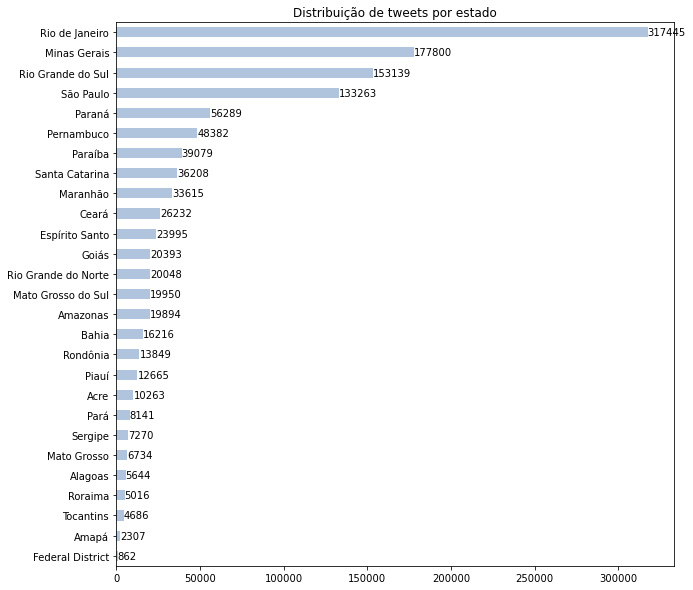

In [60]:
# Distribui√ß√£o de tweets por estado
df.state.value_counts().sort_values().plot(kind='barh', figsize=(10, 10), title='Distribui√ß√£o de tweets por estado', color='lightsteelblue')

for index, value in enumerate(df.state.value_counts().sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

#### Quantidade de *tweets* por cidade (100 maiores)

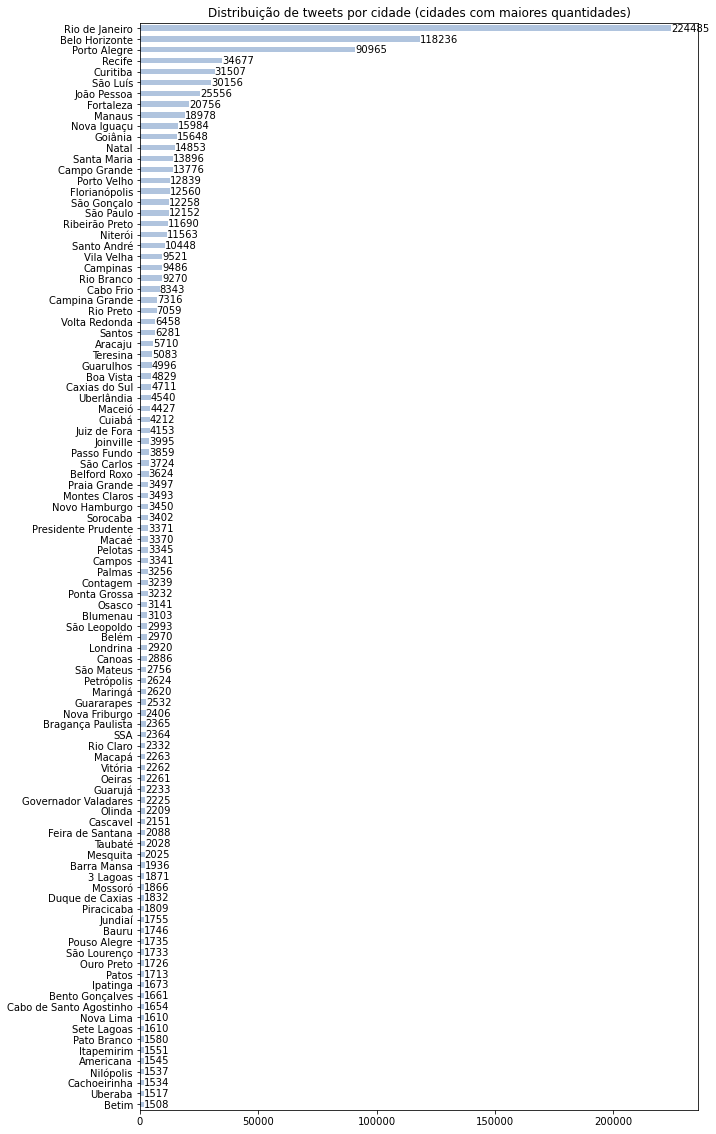

In [61]:
df_city = df.city.value_counts()[:num_max_cidades]

df_city.sort_values().plot(kind='barh', figsize=(10, 20), title='Distribui√ß√£o de tweets por cidade (cidades com maiores quantidades)', color='lightsteelblue')

for index, value in enumerate(df_city.sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

***
### Processamento das an√°lises de sentimentos por per√≠odos

Neste ponto, ser√£o iniciados os processamentos que fornecer√£o os **insumos** para a realiza√ß√£o das **an√°lises dos resultados dos sentimentos dos *tweets* nos 3 per√≠odos analisados** (antes do primeiro caso, ap√≥s o primeiro caso e ap√≥s a primeia morte), para cada cidade.

#### Fun√ß√µes auxiliares para processamento de textos

As fun√ß√µes abaixo implementam procedimentos para processamento de textos que fornecer√£o sa√≠das para as gera√ß√µes de gr√°ficos envolvendo a ocorr√™ncia de palavras em um dado conjunto de *tweets*.

A biblioteca ***NLTK*** foi utilizada para a realiza√ß√£o de tarefas como tokeniza√ß√£o e remo√ß√£o de *stopwords*.

In [70]:
import nltk
import collections

from nltk.tokenize import TweetTokenizer
from string import punctuation
from wordcloud import WordCloud, STOPWORDS

from datetime import datetime
from datetime import timedelta

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
def generate_tweets_tokens(texts):
        
    tokens = []
    
    hashtags_words = ['coronav√≠ru','coronaviru','v√≠ru','viru','corona','coronav√≠rus','coronavirus','virus','v√≠rus','covid','covid19','covid-19', '19']
    words = ['‚Äô','‚Äú','','‚Ä¶','``','...','\'\'','t','https','http','co','rt','pra','pro','vc','pq','q','p','contra','tudo','sobre','a√≠','outro','t√°','vai','ser','estar','est√°','to']
    stopwords = words + default_hashtags + hashtags_words + list(punctuation) + nltk.corpus.stopwords.words('portuguese')
    
    tweet_tokenizer = TweetTokenizer()
    
    for text in texts:        
        words = tweet_tokenizer.tokenize(text)
        for word in words:
            word.encode("ascii", errors="ignore").decode()      
            if word.lower() not in stopwords:
                tokens.append(word.lower())
   
    return tokens

In [13]:
def return_max_phrases_from_interval(df, start, end, max_res):
    
    top_words = []    
    df_query = df.loc[(df['score'] >= start) & (df['score'] < end)]

    phrases = list(df_query['text'])   
    counter = collections.Counter(phrases)
    
    return list(counter.most_common(max_res))

In [15]:
def return_tokens_from_interval(df, start, end):
    
    df_query = df.loc[(df['score'] > start) & (df['score'] < end)]

    words = list(df_query['text'])
    tokens = generate_tweets_tokens(words)
    
    return tokens

In [16]:
def return_tokens(df, column, max_items):
    
    all_tokens = []
    
    df_tokens = pd.DataFrame(columns = ['column', 'total'])

    for index, row in df.iterrows():
        tokens = row[column]
        df_current_tokens = pd.DataFrame(tokens, columns = ['column', 'total'])
        df_tokens = df_tokens.append(df_current_tokens)
        
    df_grouped = df_tokens.groupby('column')['total'].sum()
    
    for index, row in df_grouped.iteritems():
        data = [index, row]
        all_tokens.append(data)

    return all_tokens

#### Fun√ß√µes auxiliares para gera√ß√£o de gr√°ficos

In [11]:
def generate_cloud_from_tokens(tokens, color):

    df_words = pd.DataFrame(tokens, columns=['word'])

    df_freq = df_words['word'].value_counts(normalize = True).sort_values()
    wordcloud = WordCloud(background_color=color, max_words=100, normalize_plurals=False).generate_from_frequencies(df_freq.to_dict())

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [18]:
# Fun√ß√£o para gera√ß√£o de gr√°ficos
def generate_graphic(x, y, label, color, xLabel, yLabel, title, start_period, first_case, first_death):
    
    fig, ax = plt.subplots()

    ax.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    ax.grid()
    ax.margins(0) # remove default margins (matplotlib verision 2+)
    
    first_case_date = datetime.strptime(first_case, '%Y-%m-%d')
    first_death_date = datetime.strptime(first_death, '%Y-%m-%d')
    
    ax.axvspan(datetime.strptime(start_period, '%Y-%m-%d'), 
               datetime.strptime("2020-05-01", '%Y-%m-%d'), 
               fill=True, linewidth=0, color='gainsboro')
    
    plt.axvline(first_case_date, color='orange')
    plt.axvline(first_death_date, color='red')
    
    plt.rcParams['figure.figsize'] = (18,5)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')

    plt.show()

In [21]:
def generate_bar_from_filtered_tokens(tokens, max_res, word_filter, color, x, y, title):
    
    hashtags = [word for word in tokens if word_filter in word and word not in default_hashtags]
    
    if len(hashtags) > 0:
        df_hashtags = pd.DataFrame(hashtags, columns = ['column'])
        df_hashtags['column'].value_counts().sort_values()[:max_res].plot(kind='barh', figsize=(x, y), color=color, title=title)

#### Fun√ß√µes auxiliares para manipula√ß√£o de dataframes

Fun√ß√£o para a montagem de *dataframe* contendo a m√©dia de *tweets* por data para um conjunto de *dataframe* de *tweets* informado.

In [22]:
# Fun√ß√£o para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, column):

    date_set = set()  
    
    for item in df.created_at:
        date = datetime(item.year, item.month, item.day)
        date_set.add(date)
    
    # Listas utilizadas para montagem do df
    date_list = list(date_set)
    date_list.sort()
    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        # M√©dia de scores do per√≠odo
        score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
        score_mean_list.append(score_mean)
    
    # Dicion√°rio utilizado como par√¢metro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

#### Calculando datas de in√≠cio e fim dos per√≠odos

Nos itens a seguir s√£o calculadas as datas de **primeiro caso de Covid-19** e **primeira morte por Covid-19** para cada cidade, dentre as 100 selecionadas. Estas datas ser√£o utilizadas para a defini√ß√£o das datas de in√≠cio e fim dos **3 per√≠odos a serem analisados** (antes da primeiro caso, ap√≥s o primeiro caso e ap√≥s a primeira morte) para cada cidade, posteriormente.

Estas datas s√£o **calculadas automaticamente** com a utiliza√ß√£o de uma base de dados constru√≠da a partir dos **boletins das Secretarias Estaduais de Sa√∫de(SES)**. Esta base possui informa√ß√µes de casos confirmados e √≥bitos, por data, para cada munic√≠pio (1).

Durante o c√°lculo de datas de in√≠cio e fim de cada per√≠odo, s√£o **filtradas as cidades que possuem per√≠odos de no m√≠nimo 3 dias**, para minimizar o impacto de per√≠odos muito curtos no c√°lculo da m√©dia de sentimentos por per√≠odos.

O item a seguir **carrega o banco de dados com casos de Covid-19** a partir de um arquivo *CSV*:

In [23]:
# Carregando arquivo CSV contendo casos de Covid-19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

No passo adiante, ocorre a **sele√ß√£o dos registros de casos de Covid-19 de munic√≠pios pertencentes ao conjunto das 100 maiores cidades** em quantidade de tweets:

In [24]:
top_cities = list(df.city.value_counts()[:num_max_cidades].index)
df_top_cities = df.loc[df['city'].isin(top_cities)]

No processamento abaixo ocorre o **c√°lculo das datas citadas** inicialmente para cada cidade.

In [26]:
cities = df_top_cities.groupby(['city','state'])

cities_cases_date = []
initial = '2020-02-01'
final = '2020-05-01'

for item, state in cities['city','state']:
    
    city = item[0]
    state = item[1]
    
    df_cases_city = df_cases_brasil.query('city == "'+city+'"')
    df_cases_city = df_cases_city.reset_index()
    df_cases_city = df_cases_city.drop(columns=['index'])
    
    if (len(df_cases_city) > 0):
    
        # Data do primeiro caso 
        first_case = df_cases_city.loc[0, 'date']

        # Data da primeira morte
        result = df_cases_city.query('last_available_deaths != "0"')
        
        if (len(result) > 0):
            first_death = df_cases_city.loc[min(result.index), 'date']
            
            initial_date = datetime.strptime(initial, '%Y-%m-%d')
            first_case_date = datetime.strptime(first_case, '%Y-%m-%d')
            first_death_date = datetime.strptime(first_death, '%Y-%m-%d')
            final_date = datetime.strptime(final, '%Y-%m-%d')
            
            total_days1 = (first_case_date - initial_date).days
            total_days2 = (first_death_date - first_case_date).days
            total_days3 = (final_date - first_death_date).days
            
            if (total_days1 > min_num_days and total_days2 > min_num_days and total_days3 > min_num_days):
                data = [city, state, first_case, first_death]
                cities_cases_date.append(data)

df_cities_cases_date = pd.DataFrame.from_dict(cities_cases_date)
df_cities_cases_date.columns = ['city', 'state', 'first_case_date', 'first_death_date']

O *dataframe* a seguir exibe um recorte dos registros com as colunas criadas contendo as datas calculadas no processamento realizado acima:

In [76]:
df_cities_cases_date.head()

city                state first_case_date  \
1                Aracaju              Sergipe      2020-03-14   
4           Belford Roxo       Rio de Janeiro      2020-03-26   
5         Belo Horizonte         Minas Gerais      2020-03-16   
6                  Bel√©m                 Par√°      2020-03-18   
7              Boa Vista              Roraima      2020-03-21   
8              Cabo Frio       Rio de Janeiro      2020-04-07   
9         Campina Grande              Para√≠ba      2020-03-27   
10              Campinas            S√£o Paulo      2020-03-18   
11          Campo Grande   Mato Grosso do Sul      2020-03-14   
12                Canoas    Rio Grande do Sul      2020-03-21   
14              Contagem         Minas Gerais      2020-03-23   
15                Cuiab√°          Mato Grosso      2020-03-20   
16              Curitiba               Paran√°      2020-03-12   
19         Florian√≥polis       Santa Catarina      2020-03-12   
20             Fortaleza                Cear√°      2020-03-16   
21               Goi√¢nia                Goi√°s      2020-03-12   
22  Governador Valadares         Minas Gerais      2020-03-26   
24             Guarulhos            S√£o Paulo      2020-03-17   
25             Joinville       Santa Catarina      2020-03-13   
26           Jo√£o Pessoa              Para√≠ba      2020-03-18   
27          Juiz de Fora         Minas Gerais      2020-03-14   
29              Londrina               Paran√°      2020-03-17   
31                 Maca√©       Rio de Janeiro      2020-03-31   
32                Macei√≥              Alagoas      2020-03-08   
33                Manaus             Amazonas      2020-03-13   
34               Maring√°               Paran√°      2020-03-18   
36                 Natal  Rio Grande do Norte      2020-03-12   
38               Niter√≥i       Rio de Janeiro      2020-03-12   
39         Nova Friburgo       Rio de Janeiro      2020-04-04   
40           Nova Igua√ßu       Rio de Janeiro      2020-03-28   
41                Olinda           Pernambuco      2020-03-22   
43                Palmas            Tocantins      2020-03-18   
44           Passo Fundo    Rio Grande do Sul      2020-03-26   
47          Porto Alegre    Rio Grande do Sul      2020-03-11   
48           Porto Velho             Rond√¥nia      2020-03-21   
50          Praia Grande            S√£o Paulo      2020-04-01   
51                Recife           Pernambuco      2020-03-12   
52            Rio Branco                 Acre      2020-03-17   
54        Rio de Janeiro       Rio de Janeiro      2020-03-06   
55           Santo Andr√©            S√£o Paulo      2020-03-16   
56                Santos            S√£o Paulo      2020-03-30   
57            S√£o Carlos            S√£o Paulo      2020-04-06   
58           S√£o Gon√ßalo       Rio de Janeiro      2020-03-23   
59          S√£o Leopoldo    Rio Grande do Sul      2020-03-21   
60              S√£o Lu√≠s             Maranh√£o      2020-03-20   
61            S√£o Mateus       Esp√≠rito Santo      2020-03-29   
62             S√£o Paulo            S√£o Paulo      2020-02-25   
64              Teresina                Piau√≠      2020-03-19   
66            Uberl√¢ndia         Minas Gerais      2020-03-17   
67            Vila Velha       Esp√≠rito Santo      2020-03-19   

   first_death_date  score_mean  score_mean_1  score_mean_2  score_mean_3  \
1        2020-04-02   -0.050649     -0.031442     -0.029884     -0.057509   
4        2020-04-02    0.004392      0.004702     -0.018114      0.006053   
5        2020-03-30   -0.046808     -0.021647     -0.032389     -0.057984   
6        2020-04-06   -0.050234     -0.009508     -0.069118     -0.062154   
7        2020-04-03   -0.032256     -0.003825     -0.069267     -0.043530   
8        2020-04-23   -0.031188     -0.010709      0.004745     -0.044764   
9        2020-04-16   -0.054415     -0.024548     -0.096346     -0.061836   
10       2020-03-31   -0.055434     -0.033466   

Ap√≥s este processamento, o n√∫mero de cidades, **inicialmente em 100 registros, diminui para 69**. Como mostrado no c√≥digo abaixo:

In [28]:
len(df_cities_cases_date)

69

In [78]:
df_cities_cases_date.columns

Index(['city', 'state', 'first_case_date', 'first_death_date', 'score_mean',
       'score_mean_1', 'score_mean_2', 'score_mean_3', 'tokens_neg',
       'tokens_neg_1', 'tokens_neg_2', 'tokens_neg_3', 'tokens_pos',
       'tokens_pos_1', 'tokens_pos_2', 'tokens_pos_3', 'qtd_tweets',
       'qtd_tweets_1', 'qtd_tweets_2', 'qtd_tweets_3'],
      dtype='object')

#### Processamento de dados por per√≠odo

No processamento realizado a seguir ocorre a **gera√ß√£o de dados provenientes das an√°lises de sentimentos e dos conte√∫dos dos *tweets*** das cidades selecionadas at√© ent√£o. Estes dados s√£o processados **para cada cidade e para cada um dos 3 per√≠odos analisados** (antes do primeiro caso, ap√≥s o primeiro caso e ap√≥s a primeira morte).

Os intervalos de datas referentes aos per√≠odos citados s√£o detalhados abaixo:

- **Primeiro Per√≠odo**: Iniciando em 01/02/2020 (data do primeiro registro da base de dados) √† data anterior ao primeiro caso de Covid-19 na cidade;
- **Segundo Per√≠odo**: Iniciando na data do primeiro caso de Covid-19 na cidade √† data anterior √† primeira morte por Covid-19;
- **Terceiro Per√≠odo**: Iniciando na data da primeira morte por Covid-19 na cidade √† 01/05/2020 (data do √∫ltimo registro da base de dados)

Para cada um desses per√≠odos, s√£o gerados os seguintes dados que servir√£o de insumos para as an√°lises realizadas mais adiante neste trabalho:

- **M√©dia de *score* de sentimento total**;
- **M√©dia de *score* de sentimento por per√≠odo**;
- **Quantidade total de *tweets***;
- **Quantidade total de *tweets* por per√≠odo**;
- **100 palavras com maior ocorr√™ncia em frases que mais influenciaram negativamente os *scores* de sentimentos**;
- **100 palavras com maior ocorr√™ncia em frases que mais influenciaram positivamente os *scores* de sentimentos**;

Durante este procedimento, ocorre a filtragem onde s√£o consideradas somentes cidades que possuam no m√≠nimo a quantidade de 300 *tweets* por per√≠odo. Esta sele√ß√£o ajuda a minimizar o impacto no c√°lculo da m√©dia de sentimentos para per√≠odos com poucas quantidade de *tweets*.

In [14]:
def return_max_tokens_from_interval(df, start, end, max_tokens):
    
    top_words = []    
    df_query = df.loc[(df['score'] >= start) & (df['score'] < end)]

    words = list(df_query['text'])
    tokens = generate_tweets_tokens(words)    
    counter = collections.Counter(tokens)
    
    return list(counter.most_common(max_tokens))

In [29]:
# Quantidade m√≠nima de tweets aceit√°veis para cada per√≠odo
min_tweets = 100

# Quantidade m√°xima de tokens a serem retornadas para cada frase analisada
max_tokens = 100

In [30]:
score_mean = []
score_mean_1 = []
score_mean_2 = []
score_mean_3 = []

qtd_tweets = []
qtd_tweets_1 = []
qtd_tweets_2 = []
qtd_tweets_3 = []

tokens_neg = []
tokens_neg_1 = []
tokens_neg_2 = []
tokens_neg_3 = []

tokens_pos = []
tokens_pos_1 = []
tokens_pos_2 = []
tokens_pos_3 = []

total_processed = 0

for index, row in df_cities_cases_date.iterrows():
    
    city = row['city']
    
    total_processed = total_processed + 1
    
    df_tweets = df.query('city == "'+city+'"')
    df_tweets_1 = df_tweets.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case+' 00:00:00"')  
    df_tweets_2 = df_tweets.query('created_at >= "'+first_case+' 00:00:00" and created_at < "'+first_death+' 00:00:00"')
    df_tweets_3 = df_tweets.query('created_at >= "'+first_death+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
    
    if (len(df_tweets_1) >= min_tweets and len(df_tweets_2) >= min_tweets and len(df_tweets_3) >= min_tweets):
        
        score_mean.append(mean(df_tweets['score']))        
        score_mean_1.append(mean(df_tweets_1['score']))
        score_mean_2.append(mean(df_tweets_2['score']))
        score_mean_3.append(mean(df_tweets_3['score']))
    
        start = df_tweets['score'].describe()['min']
        end = df_tweets['score'].describe()['25%']

        tokens_city_neg = return_max_tokens_from_interval(df_tweets, start, end, max_tokens)
        tokens_city_neg_1 = return_max_tokens_from_interval(df_tweets_1, start, end, max_tokens)
        tokens_city_neg_2 = return_max_tokens_from_interval(df_tweets_2, start, end, max_tokens)
        tokens_city_neg_3 = return_max_tokens_from_interval(df_tweets_3, start, end, max_tokens)

        tokens_neg.append(tokens_city_neg)
        tokens_neg_1.append(tokens_city_neg_1)
        tokens_neg_2.append(tokens_city_neg_2)
        tokens_neg_3.append(tokens_city_neg_3)

        start = df_tweets['score'].describe()['75%']
        end = df_tweets['score'].describe()['max']

        tokens_city_pos = return_max_tokens_from_interval(df_tweets, start, end, max_tokens)
        tokens_city_pos_1 = return_max_tokens_from_interval(df_tweets_1, start, end, max_tokens)
        tokens_city_pos_2 = return_max_tokens_from_interval(df_tweets_2, start, end, max_tokens)
        tokens_city_pos_3 = return_max_tokens_from_interval(df_tweets_3, start, end, max_tokens)

        tokens_pos.append(tokens_city_pos)
        tokens_pos_1.append(tokens_city_pos_1)
        tokens_pos_2.append(tokens_city_pos_2)
        tokens_pos_3.append(tokens_city_pos_3)
        
        qtd_tweets.append(len(df_tweets))
        qtd_tweets_1.append(len(df_tweets_1))
        qtd_tweets_2.append(len(df_tweets_2))
        qtd_tweets_3.append(len(df_tweets_3))
        
    else:
        df_cities_cases_date = df_cities_cases_date.drop(index)
        
    print(total_processed,'processado(s)')
    
df_cities_cases_date['score_mean'] = score_mean
df_cities_cases_date['score_mean_1'] = score_mean_1
df_cities_cases_date['score_mean_2'] = score_mean_2
df_cities_cases_date['score_mean_3'] = score_mean_3

df_cities_cases_date['tokens_neg'] = tokens_neg
df_cities_cases_date['tokens_neg_1'] = tokens_neg_1
df_cities_cases_date['tokens_neg_2'] = tokens_neg_2
df_cities_cases_date['tokens_neg_3'] = tokens_neg_3

df_cities_cases_date['tokens_pos'] = tokens_pos
df_cities_cases_date['tokens_pos_1'] = tokens_pos_1
df_cities_cases_date['tokens_pos_2'] = tokens_pos_2
df_cities_cases_date['tokens_pos_3'] = tokens_pos_3

df_cities_cases_date['qtd_tweets'] = qtd_tweets
df_cities_cases_date['qtd_tweets_1'] = qtd_tweets_1
df_cities_cases_date['qtd_tweets_2'] = qtd_tweets_2
df_cities_cases_date['qtd_tweets_3'] = qtd_tweets_3

1 processado(s)
2 processado(s)
3 processado(s)
4 processado(s)
5 processado(s)
6 processado(s)
7 processado(s)
8 processado(s)
9 processado(s)
10 processado(s)
11 processado(s)
12 processado(s)
13 processado(s)
14 processado(s)
15 processado(s)
16 processado(s)
17 processado(s)
18 processado(s)
19 processado(s)
20 processado(s)
21 processado(s)
22 processado(s)
23 processado(s)
24 processado(s)
25 processado(s)
26 processado(s)
27 processado(s)
28 processado(s)
29 processado(s)
30 processado(s)
31 processado(s)
32 processado(s)
33 processado(s)
34 processado(s)
35 processado(s)
36 processado(s)
37 processado(s)
38 processado(s)
39 processado(s)
40 processado(s)
41 processado(s)
42 processado(s)
43 processado(s)
44 processado(s)
45 processado(s)
46 processado(s)
47 processado(s)
48 processado(s)
49 processado(s)
50 processado(s)
51 processado(s)
52 processado(s)
53 processado(s)
54 processado(s)
55 processado(s)
56 processado(s)
57 processado(s)
58 processado(s)
59 processado(s)
60 pro

Recorte do *dataframe* contendo os dados gerados para cada cidade e cada per√≠odo realizados acima:

In [31]:
df_cities_cases_date.head()

city           state first_case_date first_death_date  \
1         Aracaju         Sergipe      2020-03-14       2020-04-02   
4    Belford Roxo  Rio de Janeiro      2020-03-26       2020-04-02   
5  Belo Horizonte    Minas Gerais      2020-03-16       2020-03-30   
6           Bel√©m            Par√°      2020-03-18       2020-04-06   
7       Boa Vista         Roraima      2020-03-21       2020-04-03   

   score_mean  score_mean_1  score_mean_2  score_mean_3  \
1   -0.050649     -0.031442     -0.029884     -0.057509   
4    0.004392      0.004702     -0.018114      0.006053   
5   -0.046808     -0.021647     -0.032389     -0.057984   
6   -0.050234     -0.009508     -0.069118     -0.062154   
7   -0.032256     -0.003825     -0.069267     -0.043530   

                                          tokens_neg  \
1  [(brasil, 151), (bolsonaro, 99), (casos, 85), ...   
4  [(brasil, 54), (morrer, 54), (gente, 52), (m√£e...   
5  [(brasil, 2479), (bolsonaro, 2046), (pessoas, ...   
6  [(üò≠, 77), (pessoas, 65), (casa, 65), (ainda, 5...   
7  [(casos, 84), (roraima, 81), (brasil, 72), (pe...   

                                        tokens_neg_1  \
1  [(brasil, 17), (agora, 16), (gripe, 15), (pess...   
4  [(morrer, 25), (nunca, 23), (gente, 22), (agor...   
5  [(brasil, 432), (gente, 432), (causa, 389), (c...   
6  [(brasil, 12), (pessoas, 10), (faz, 10), (gent...   
7  [(gente, 20), (agora, 19), (brasil, 18), (comb...   

                                        tokens_neg_2  \
1  [(bolsonaro, 9), (dois, 5), (pa√≠s, 5), (hospit...   
4  [(todo, 7), (mundo, 6), (quarentena, 5), (medo...   
5  [(bolsonaro, 142), (brasil, 95), (pessoas, 87)...   
6  [(bolsonaro, 5), (vou, 4), (matar, 4), (toda, ...   
7  [(leitos, 16), (doou, 10), (outros, 9), (sa√∫de...   

                                        tokens_neg_3  \
1  [(brasil, 133), (bolsonaro, 80), (casos, 75), ...   
4  [(brasil, 35), (m√£e, 30), (gente, 26), (üò≠, 26)...   
5  [(brasil, 1952), (bolsonaro, 1581), (mortos, 1...   
6  [(üò≠, 72), (casa, 55), (pessoas, 53), (gente, 3...   
7  [(casos, 71), (roraima, 66), (pessoas, 64), (c...   

                                          tokens_pos  \
1  [(casos, 165), (brasil, 139), (Ô∏è, 82), (mat√©ri...   
4  [(deus, 80), (ü§£, 75), (üòÇ, 64), (amor, 61), (ca...   
5  [(brasil, 1853), (agora, 1247), (dia, 1223), (...   
6  [(pessoas, 53), (deus, 51), (gente, 45), (bom,...   
7  [(casos, 124), (casa, 93), (agora, 85), (boa, ...   

                                        tokens_pos_1  \
1  [(brasil, 21), (governo, 16), (aqui, 16), (sa√∫...   
4  [(paulo, 42), (resto, 42), (pa√≠s, 41), (ningu√©...   
5  [(pa√≠s, 431), (gente, 389), (brasil, 388), (ni...   
6  [(bom, 12), (quarentena, 11), (üòÇ, 11), (deus, ...   
7  [(casa, 44), (boa, 43), (casos, 41), (2, 36), ...   

                                        tokens_pos_2  \
1  [(brasil, 7), (parab√©ns, 6), (pode, 6), (presi...   
4  [(deus, 8), (calma, 7), (ainda, 7), (casa, 6),...   
5  [(deus, 121), (casa, 117), (t√¥, 115), (preside...   
6  [(4, 4), (brasil, 4), (1, 3), (2, 3), (quarent...   
7  [(üòÇ, 7), (trabalhar, 5), (r, 4), (üòò, 4), (part...   

                                        tokens_pos_3  qtd_tweets  \
1  [(casos, 154), (brasil, 111), (Ô∏è, 78), (mat√©ri...        5710   
4  [(deus, 61), (ü§£, 51), (amor, 48), (üôå, 42), (em...        3624   
5  [(brasil, 1418), (agora, 942), (dia, 923), (ca...      118236   
6  [(pessoas, 41), (deus, 40), (gente, 33), (Ô∏è, 3...        2970   
7  [(casos, 81), (agora, 73), (confirmados, 57), ...        4829   

   qtd_tweets_1  qtd_tweets_2  qtd_tweets_3  
1          1297           194          4219  
4          1451           168          2005  
5         32924          4885         80427  
6           689           125          2156  
7          1517           225          3087

Ap√≥s o processamento, o n√∫mero de cidades consideradas para an√°lise **diminuiu de 69 para 50 cidades**, como visto no c√≥digo abaixo:

In [32]:
len(df_cities_cases_date)

50

***
### Resultados obtidos

Os itens a seguir apresentam gr√°ficos e m√©tricas estat√≠sticas de forma a auxiliar a interpreta√ß√£o dos resultados decorrente dos dados gerados a partir dos conte√∫dos dos *tweets* das cidades analisados, para cada per√≠odo analisado.

**Gr√°ficos de cidades com menores e maiores m√©dias de *scores de sentimentos***

10 cidades com **menores m√©dias de *scores*** de sentimentos

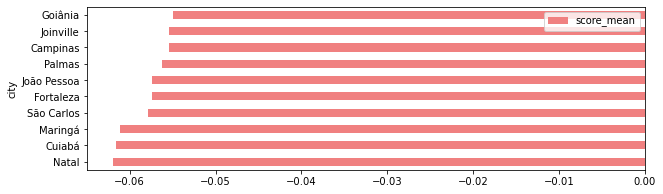

In [133]:
df_cities_neg = df_cities_cases_date.sort_values(by=['score_mean'], ascending=True)[:10]
df_cities_neg.plot(kind='barh', x='city', y='score_mean', figsize=(10, 3), color='lightcoral')

10 cidades com **maiores m√©dias de *scores* de sentimentos**

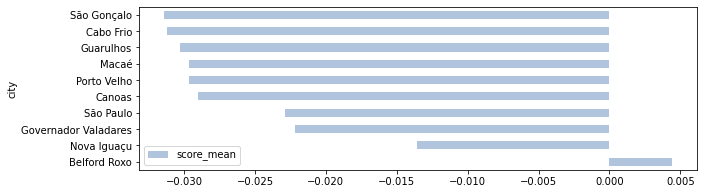

In [134]:
df_cities_pos = df_cities_cases_date.sort_values(by=['score_mean'], ascending=False)[:10]
df_cities_pos.plot(kind='barh', x='city', y='score_mean', figsize=(10, 3), color='lightsteelblue')

***
**Boxplots**

10 cidades com **menores m√©dias de *scores* de sentimentos**

In [35]:
df_cities_neg['score_mean'].describe()

count    10.000000
mean     -0.057929
std       0.002663
min      -0.061920
25%      -0.060287
50%      -0.057419
75%      -0.055624
max      -0.054979
Name: score_mean, dtype: float64

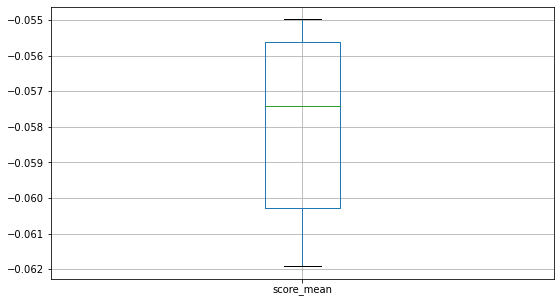

In [36]:
boxplot = df_cities_neg.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

10 cidades com **maiores m√©dias de *scores* de sentimentos**

In [37]:
df_cities_pos['score_mean'].describe()

count    10.000000
mean     -0.023543
std       0.011318
min      -0.031394
25%      -0.030147
50%      -0.029322
75%      -0.022361
max       0.004392
Name: score_mean, dtype: float64

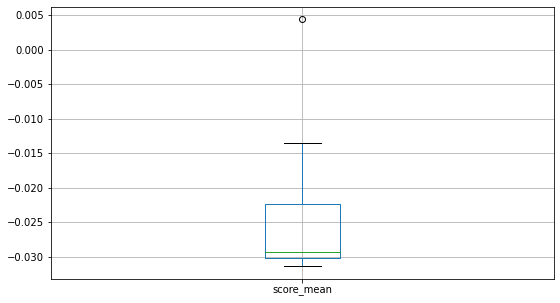

In [85]:
boxplot = df_cities_pos.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

**Notas**

De acordo com as m√©tricas obtidas acima:
- Os *scores* das 10 cidades com **menores m√©dias** de sentimentos **variam de -0.061920 a -0.054979**, com **m√©dia de -0.057929**.
- Os *scores* das 10 cidades com **maiores m√©dias** de sentimentos **variam de -0.031394 a 0.004392**, com **m√©dia de -0.023543**.

Observa-se que os dois conjuntos analisados possuem **m√©dias de *scores* de sentimentos negativos e bem pr√≥ximos a zero**. O que pode ser um indicativo de **neutralidade** em rela√ß√£o aos sentimentos de *tweets* dos conjuntos analisados. 

***
**Gr√°fico de Barras**

*Fun√ß√µes auxiliares*

In [228]:
def generate_means_bars(df):
    
    bar_width = 0.25

    means_1 = list(df['score_mean_1'])
    means_2 = list(df['score_mean_2'])
    means_3 = list(df['score_mean_3'])

    # Cria eixo x para produto A e produto B com uma separa√ß√£o de 0.25 entre as barras
    x1 =  np.arange(len(means_1))
    x2 = [x + bar_width for x in x1]
    x3 = [x + bar_width for x in x2]

    # Plota as barras
    plt.bar(x1, means_1, width=bar_width, label = 'Antes do 1¬∫ caso', color = 'moccasin')
    plt.bar(x2, means_2, width=bar_width, label = 'Ap√≥s o 1¬∫ caso', color = 'sandybrown')
    plt.bar(x3, means_3, width=bar_width, label = 'Ap√≥s a 1¬™ morte', color = 'indianred')

    # coloca o nome dos meses como label do eixo x
    cities = list(df['city'])
    plt.xticks([x + bar_width for x in range(len(means_1))], cities)

    # inseri uma legenda no gr√°fico
    plt.legend()

    plt.title("M√©dias de scores de sentimentos por per√≠odo")
    plt.show()

Cidades com **menores m√©dias** de sentimentos

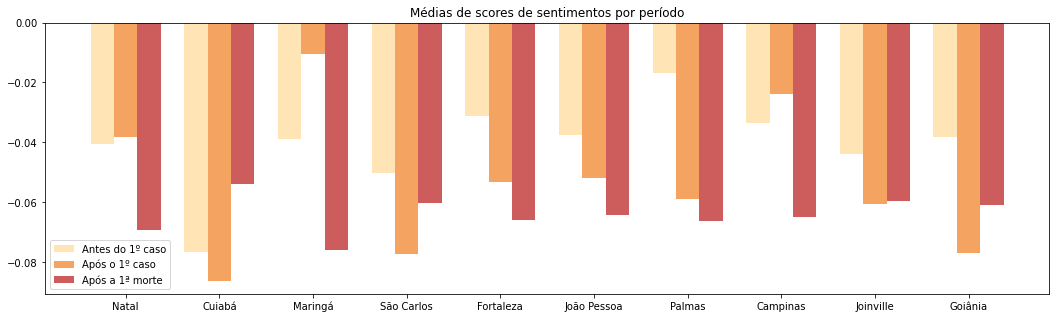

In [229]:
generate_means_bars(df_cities_neg)

Cidades com **maiores m√©dias** de sentimentos

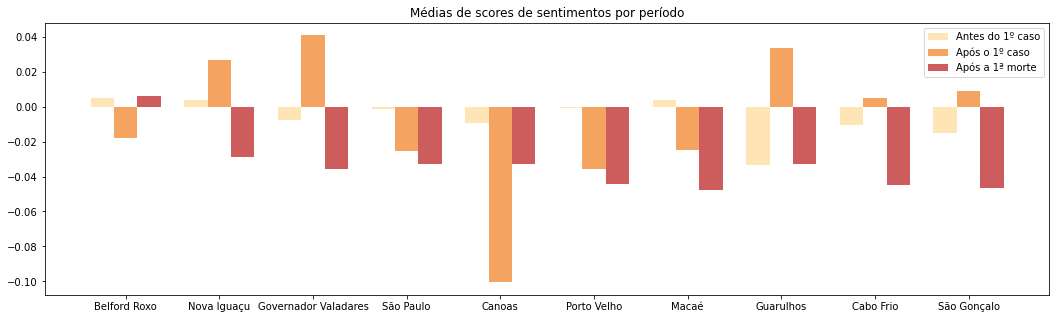

In [230]:
generate_means_bars(df_cities_pos)

**M√©dia de *scores* de sentimento por dia**

*Fun√ß√µes utilizadas na gera√ß√£o dos gr√°ficos*

In [42]:
def generate_daily_graphic(df, df_brasil):
    
    for index, row in df.iterrows():
    
        city = row['city']
        state = row['state']
        first_case_date = row['first_case_date']
        first_death_date = row['first_death_date']

        df_city = df_brasil.query('city == "'+city+'"')
        df_scores_city = building_dates_df(df_city, 'score')

        x = df_scores_city.created_at
        y = df_scores_city.score_mean

        color = 'dimgrey'

        label = 'M√©dias'
        xLabel = 'Data'
        yLabel = 'M√©dias'

        title = city + ' - ' + state

        generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, '2020-02-01', first_case_date, first_death_date)

In [17]:
# Fun√ß√£o para gera√ß√£o de gr√°ficos
def generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, restriction, first_case, first_death):
    
    fig, ax = plt.subplots()

    ax.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    ax.grid()
    ax.margins(0) # remove default margins (matplotlib verision 2+)
    
    first_case_date = datetime.strptime(first_case, '%Y-%m-%d')
    first_death_date = datetime.strptime(first_death, '%Y-%m-%d')
    
    if (restriction != None):
        restriction_date = datetime.strptime(restriction, '%Y-%m-%d')
        plt.axvline(restriction_date, color='red')
    
    ax.axvspan(first_case_date, 
               first_death_date,
               fill=True, linewidth=0, color='moccasin')
    
    ax.axvspan(first_death_date, 
               datetime.strptime("2020-05-01", '%Y-%m-%d'), 
               fill=True, linewidth=0, color='gainsboro')
    
    plt.rcParams['figure.figsize'] = (18,5)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')

    plt.show()

Cidades com **menores m√©dias** de sentimentos

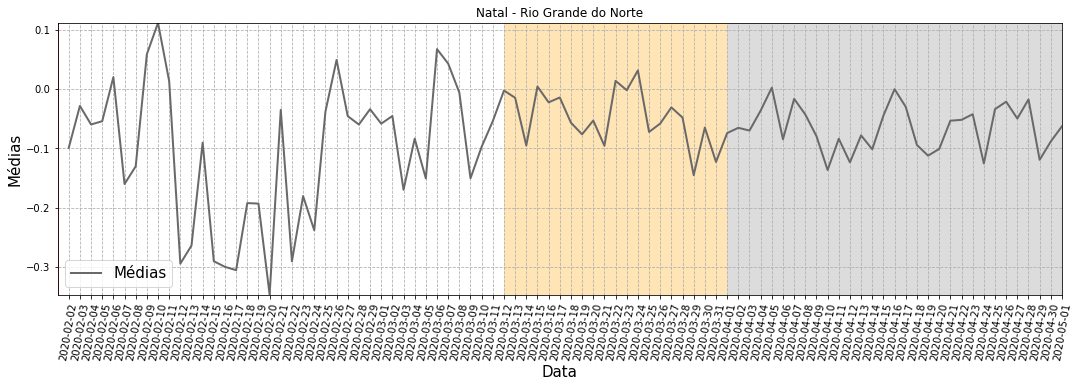

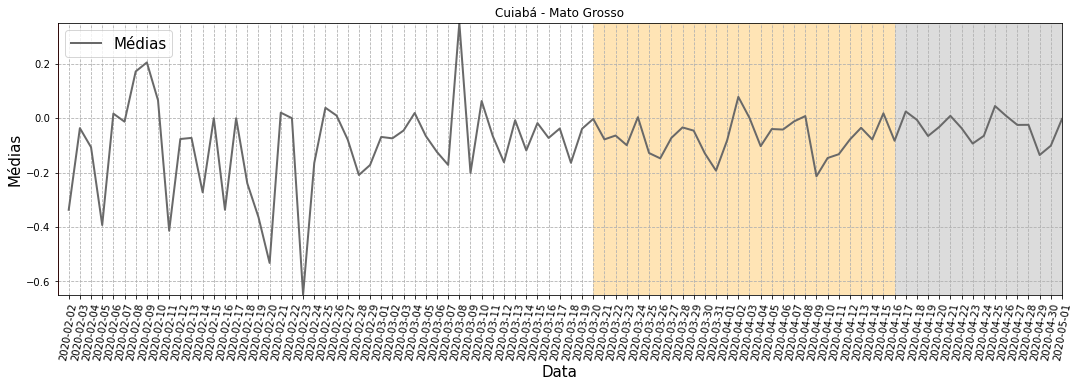

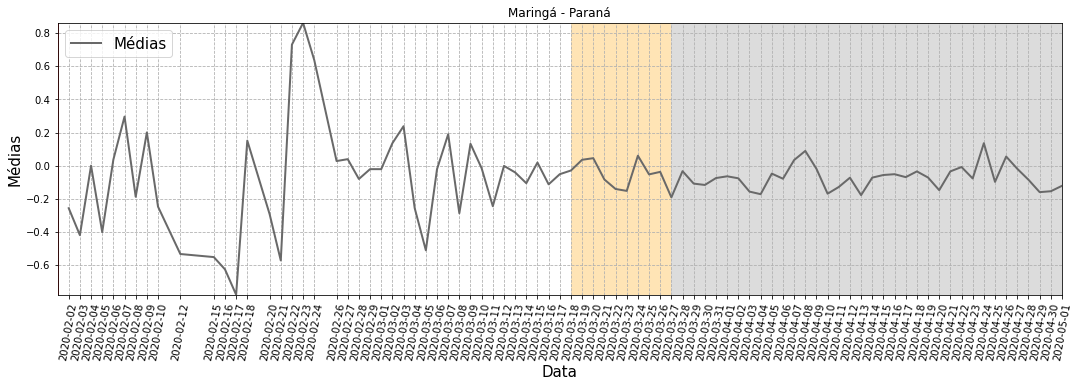

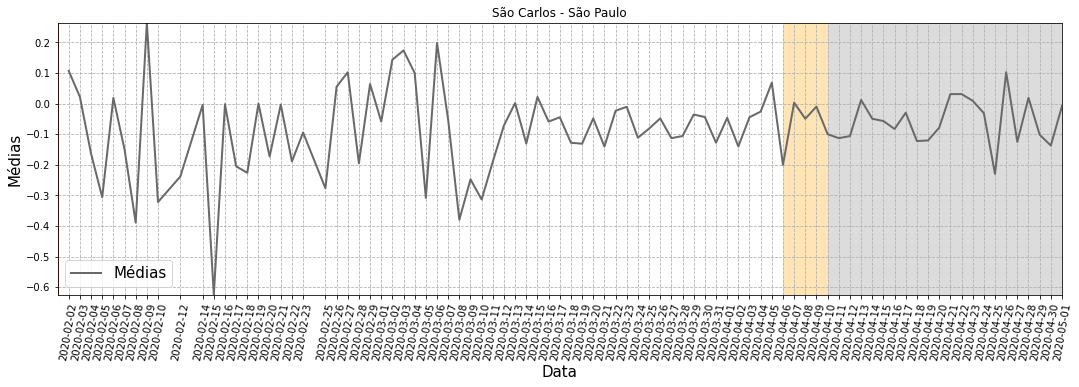

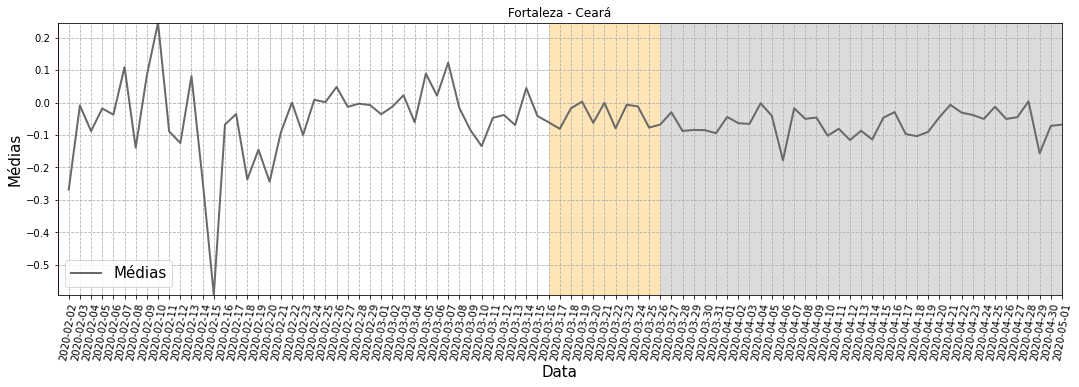

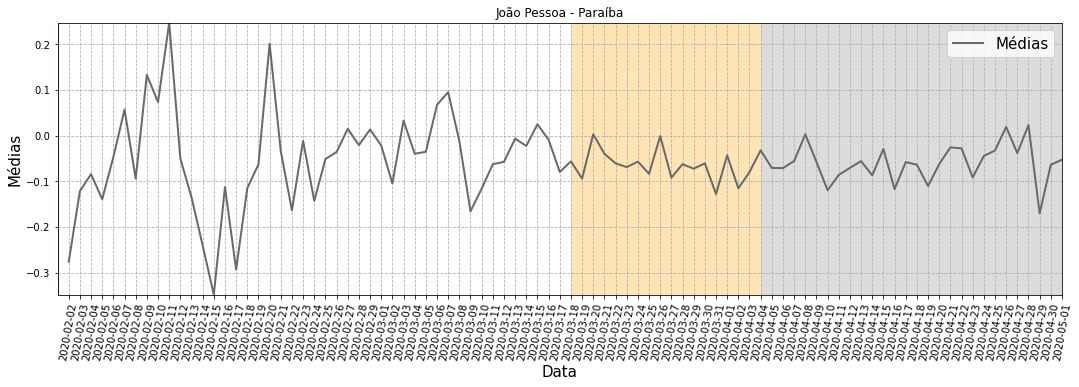

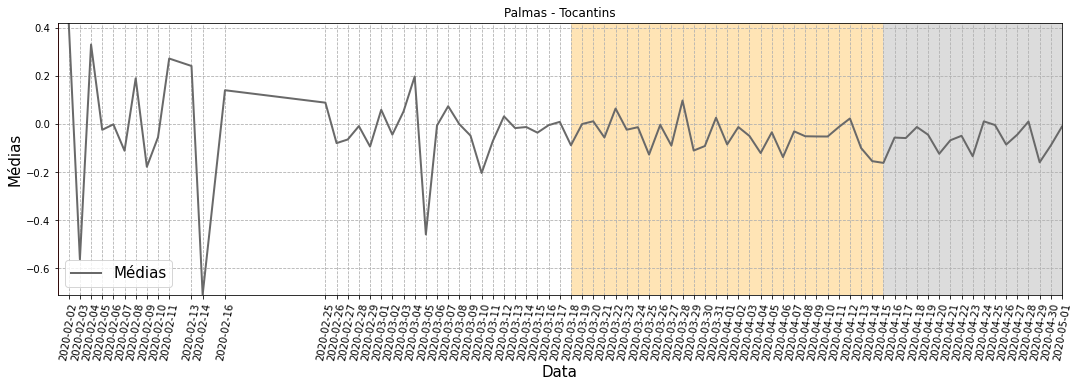

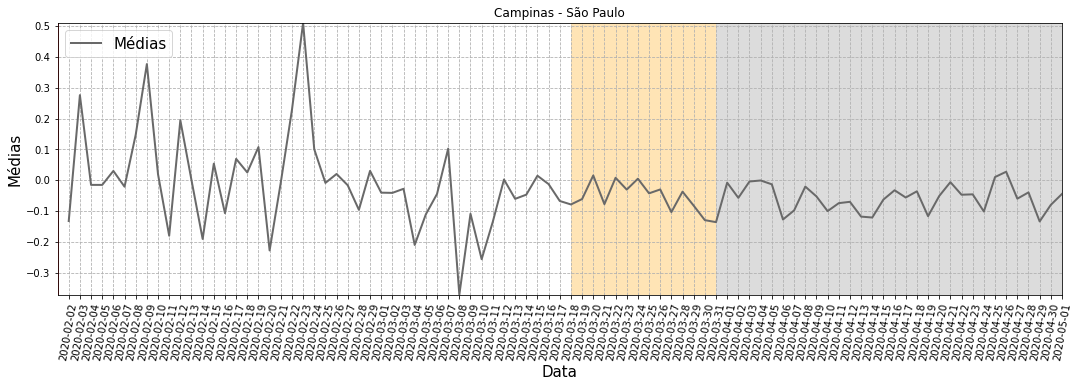

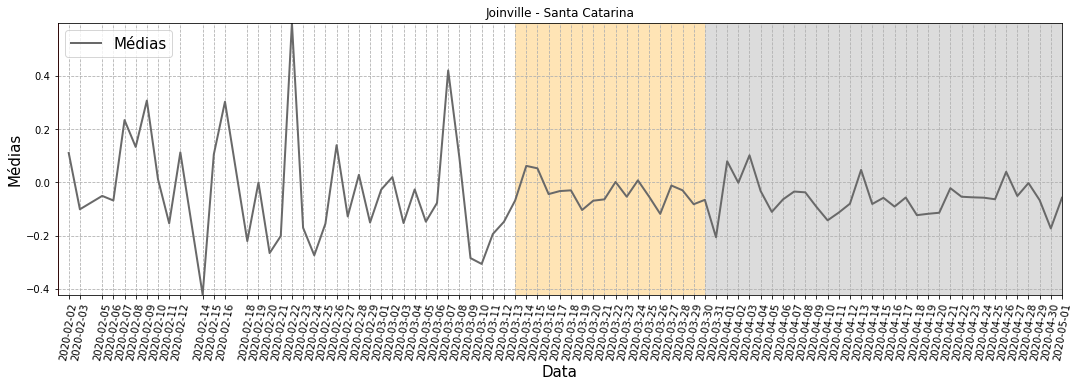

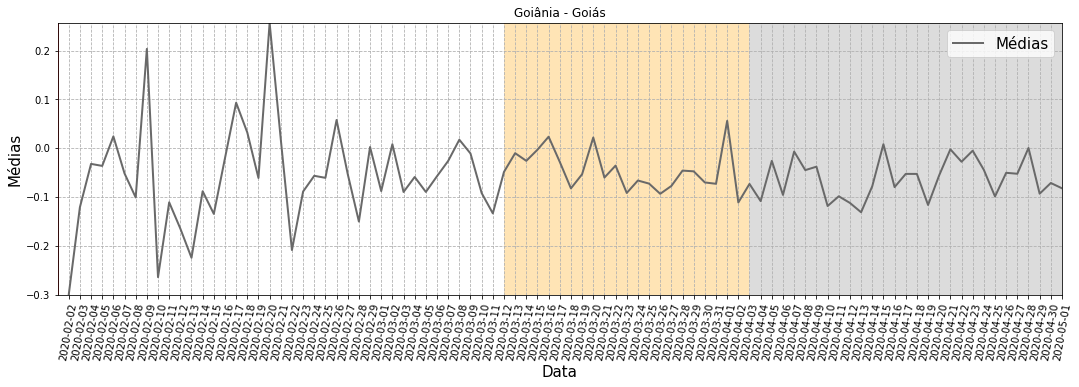

In [58]:
generate_daily_graphic(df_cities_neg, df)

Cidades com **maiores m√©dias** de sentimentos

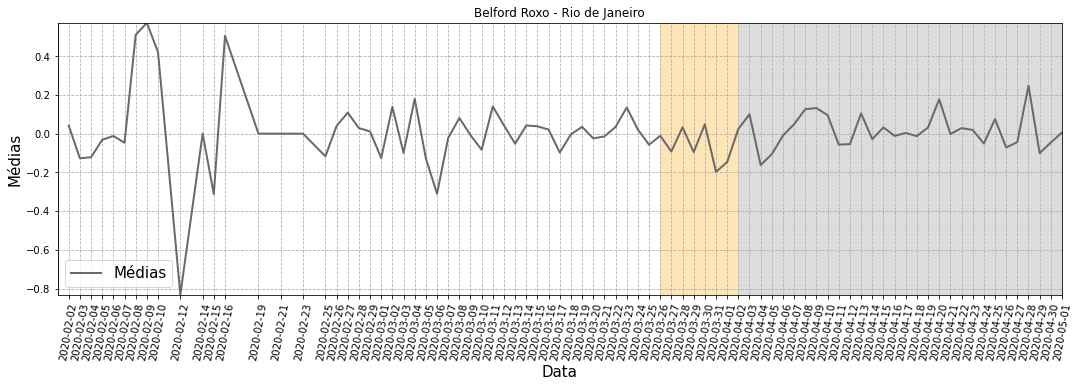

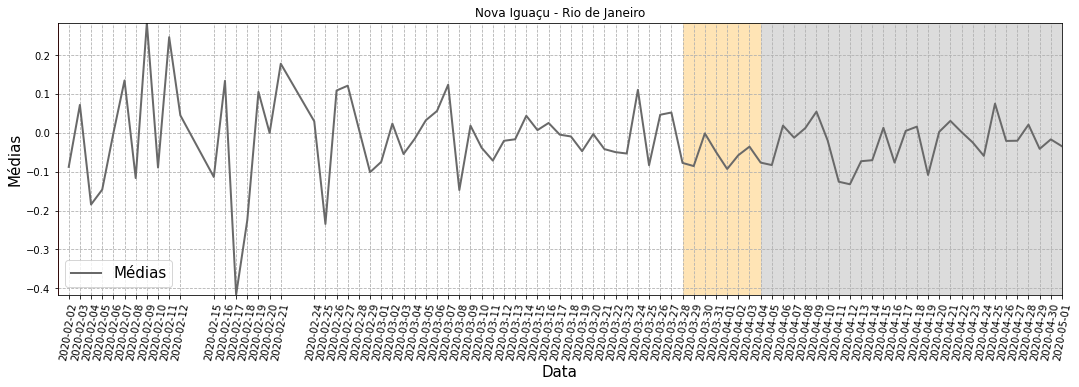

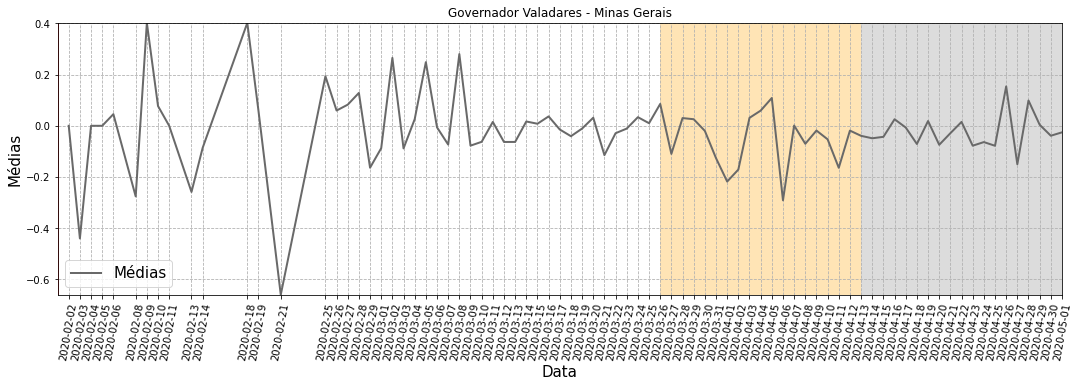

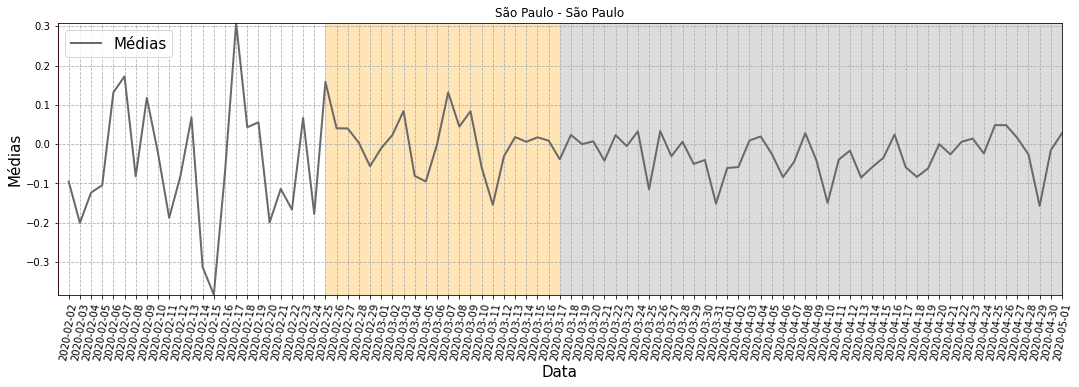

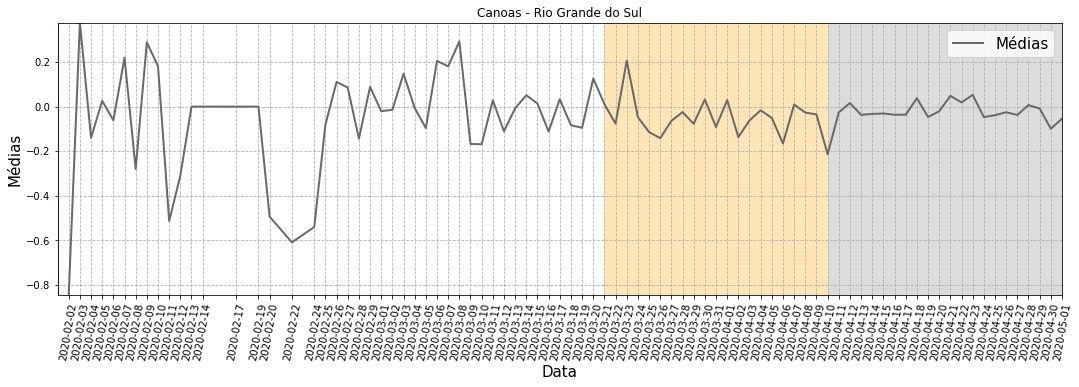

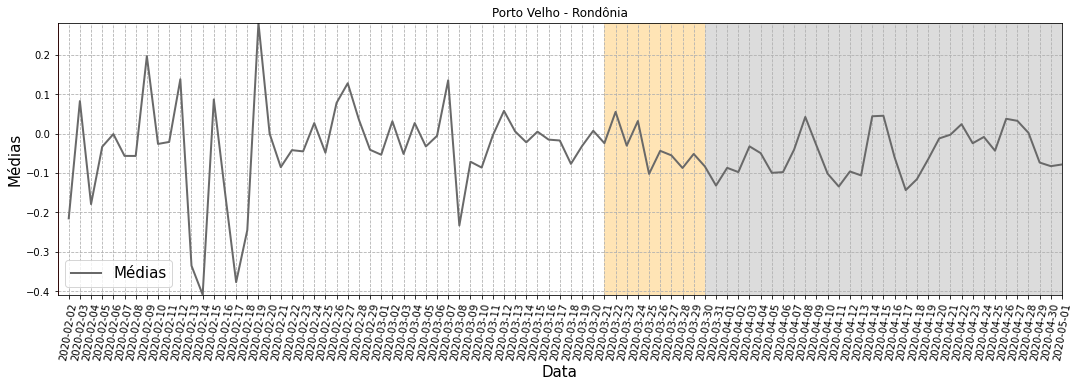

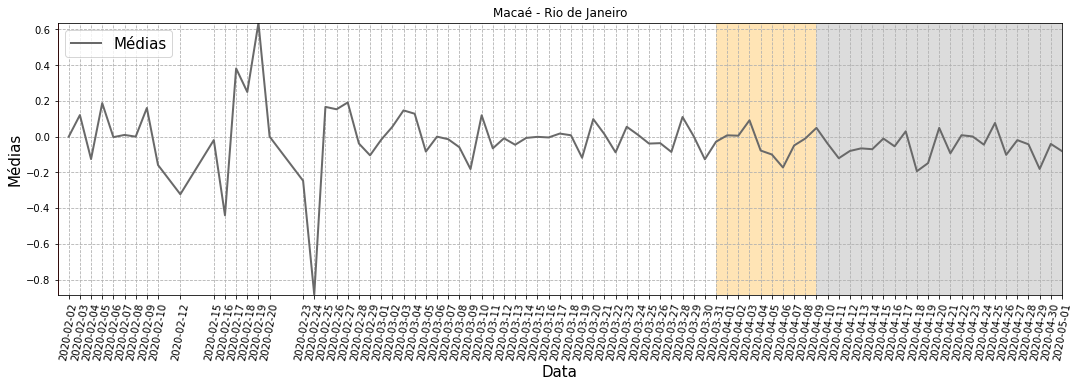

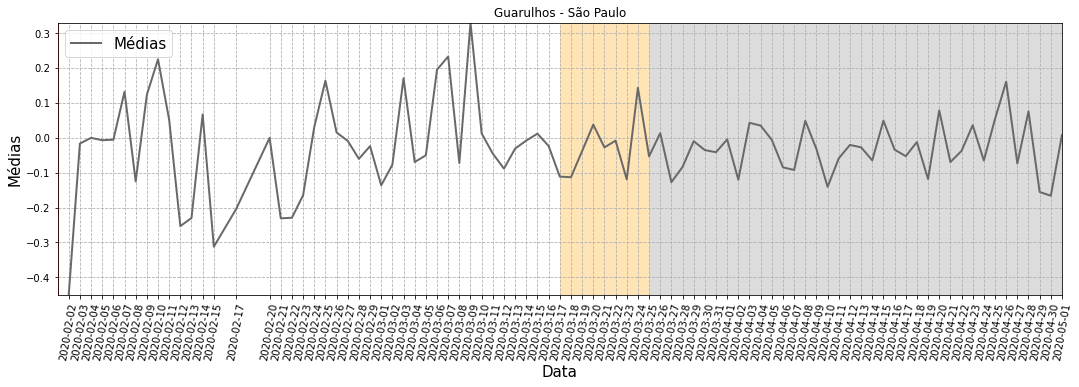

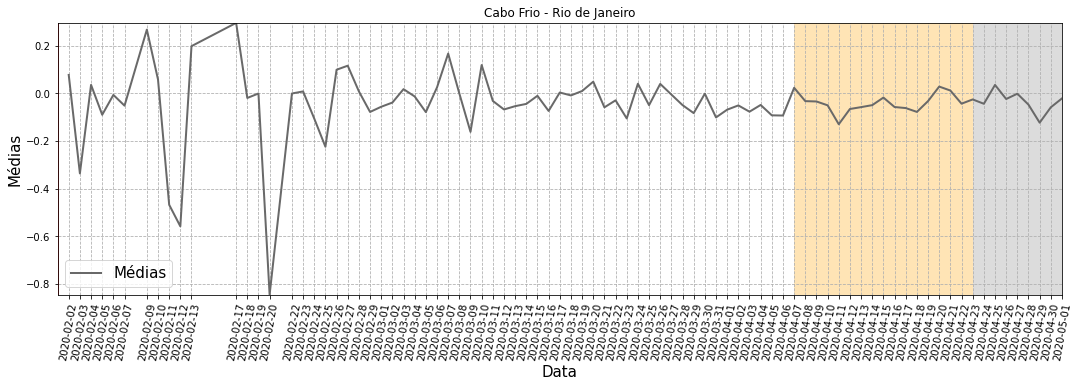

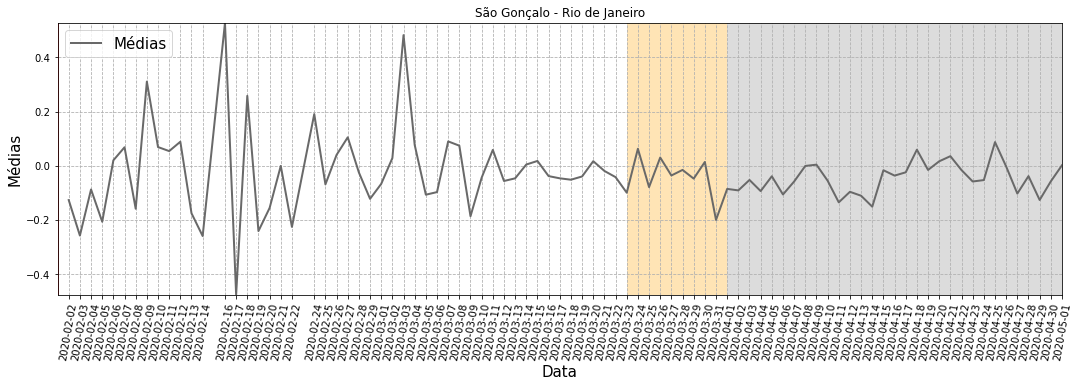

In [44]:
generate_daily_graphic(df_cities_pos, df)

**Palavras presentes nos tweets que mais influenciaram negativamente/positivamente**

*Fun√ß√µes utilizadas para gera√ß√µes de gr√°ficos*

In [79]:
def generate_bar_from_tokens_freq(tokens_freq, max_res, color, x, y, title):
    
    if len(tokens_freq) > 0:           
        df_words = pd.DataFrame(tokens_freq, columns=['column','total'])
        df_words = df_words.sort_values(by = ['total'], ascending=[False])
        df_words[:max_res].plot(kind='barh', x='column',y='total', figsize=(x, y), color=color, title=title)

In [66]:
max_res = 5

Primeiro Per√≠odo (Sem Casos)

- Cidades com **menores m√©dias** de sentimentos - Palavras que influenciam **negativamente**

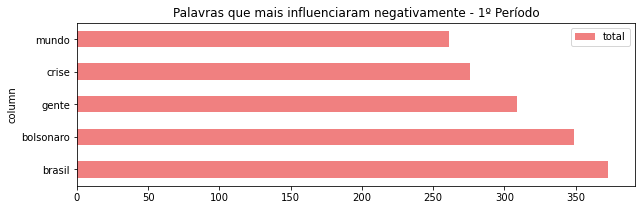

In [67]:
title = 'Palavras que mais influenciaram negativamente - 1¬∫ Per√≠odo'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg_1', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **maiores m√©dias** de sentimentos - Palavras que influenciam **negativamente**

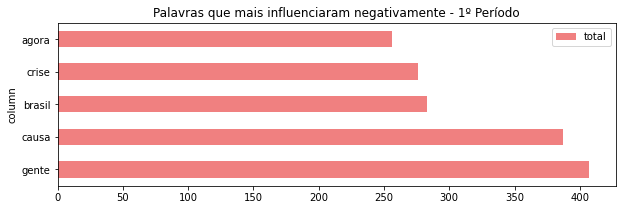

In [47]:
title = 'Palavras que mais influenciaram negativamente - 1¬∫ Per√≠odo'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg_1', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **menores m√©dias** de sentimentos - Palavras que influenciam **positivamente**

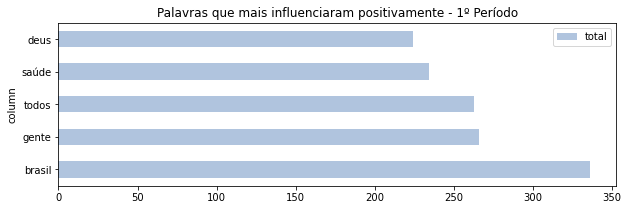

In [48]:
title = 'Palavras que mais influenciaram positivamente - 1¬∫ Per√≠odo'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos_1', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

- Cidades com **maiores m√©dias** de sentimentos - Palavras que influenciam **positivamente**

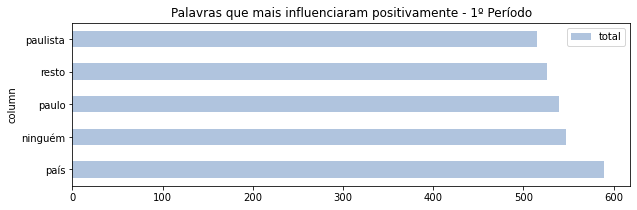

In [49]:
title = 'Palavras que mais influenciaram positivamente - 1¬∫ Per√≠odo'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos_1', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

Segundo Per√≠odo (Ap√≥s 1¬∫ caso)

- Cidades com **menores m√©dias** de sentimentos - Palavras que influenciam **negativamente**

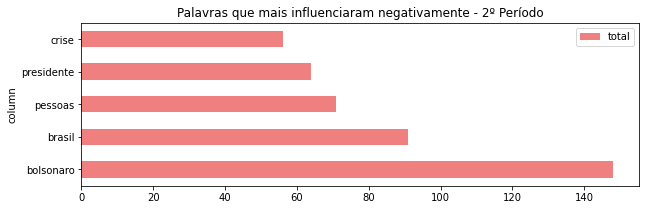

In [50]:
title = 'Palavras que mais influenciaram negativamente - 2¬∫ Per√≠odo'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg_2', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **maiores m√©dias** de sentimentos - Palavras que influenciam **negativamente**

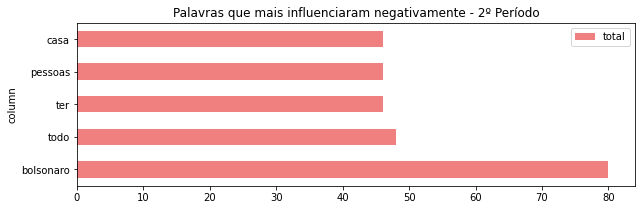

In [51]:
title = 'Palavras que mais influenciaram negativamente - 2¬∫ Per√≠odo'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg_2', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **menores m√©dias** de sentimentos - Palavras que influenciam **positivamente**

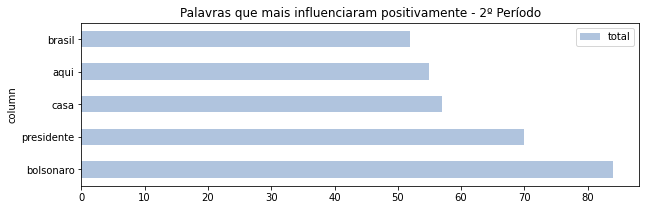

In [52]:
title = 'Palavras que mais influenciaram positivamente - 2¬∫ Per√≠odo'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos_2', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

- Cidades com **maiores m√©dias** de sentimentos - Palavras que influenciam **positivamente**

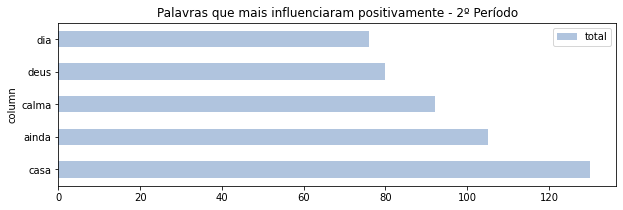

In [53]:
title = 'Palavras que mais influenciaram positivamente - 2¬∫ Per√≠odo'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos_2', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

Terceiro Per√≠odo (Ap√≥s 1¬™ morte)

- Cidades com **menores m√©dias** de sentimentos - Palavras que influenciam **negativamente**

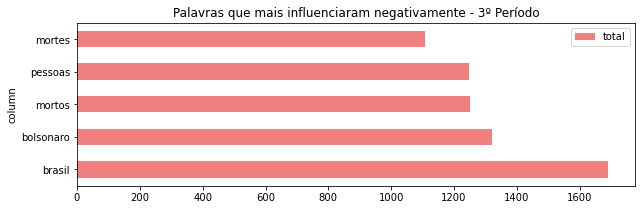

In [54]:
title = 'Palavras que mais influenciaram negativamente - 3¬∫ Per√≠odo'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg_3', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **maiores m√©dias** de sentimentos - Palavras que influenciam **negativamente**

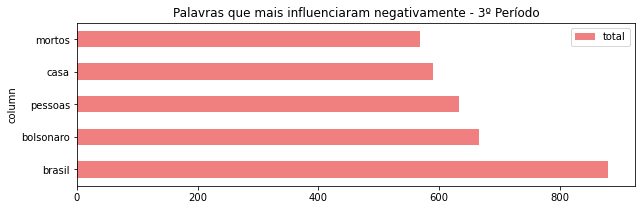

In [55]:
title = 'Palavras que mais influenciaram negativamente - 3¬∫ Per√≠odo'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg_3', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **menores m√©dias** de sentimentos - Palavras que influenciam **positivamente**

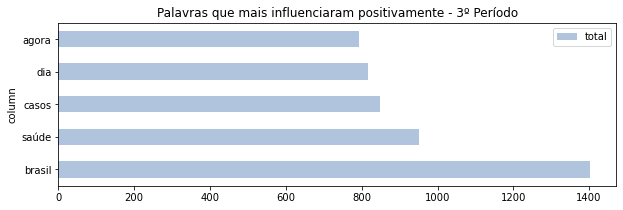

In [56]:
title = 'Palavras que mais influenciaram positivamente - 3¬∫ Per√≠odo'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos_3', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

- Cidades com **maiores m√©dias** de sentimentos - Palavras que influenciam **positivamente**

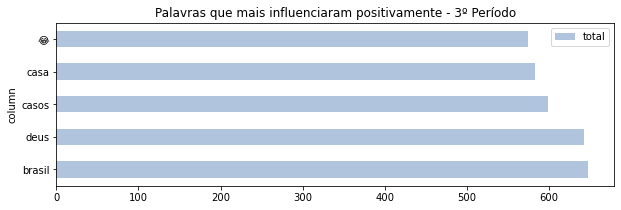

In [57]:
title = 'Palavras que mais influenciaram positivamente - 3¬∫ Per√≠odo'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos_3', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

***
### Fontes

(1) Brasil.io - Boletins informativos e casos do coronav√≠rus por munic√≠pio por dia -https://brasil.io/dataset/covid19/caso_full/